<a href="https://colab.research.google.com/github/bisu617/MLPC-ko-lagi/blob/main/MLPC_Genetic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Setting up seed for reproducibility
np.random.seed(42)

# setting parameters
num_nodes = 10
num_sources = 3
num_hours = 24

# 1. Generating Node-Hour Demand

demand_data = []
for node in range(1, num_nodes + 1):
    for hour in range(1, num_hours + 1):
        demand_kwh = np.random.randint(5, 16)  # 5–15 kWh
        demand_data.append([node, hour, demand_kwh])

df_demand = pd.DataFrame(demand_data, columns=["Node", "Hour", "Demand_kWh"])

# 2.Generating Source-Hour Cost and Capacity

source_profile = []
for source in range(1, num_sources + 1):
    for hour in range(1, num_hours + 1):
        cost = round(np.random.uniform(2.0 + source, 3.5 + source), 2)     # Cost/kWh increases with source
        capacity = np.random.randint(50, 101)  # Source capacity between 50–100 kWh
        source_profile.append([source, hour, cost, capacity])

df_source = pd.DataFrame(source_profile, columns=["Source", "Hour", "Cost_per_kWh", "Capacity_kWh"])


# 3.Creating Loss Of Coefficients
loss_data = []
for source in range(1, num_sources + 1):
    for node in range(1, num_nodes + 1):
        loss = round(np.random.uniform(0.05, 0.2), 3)  # 5–20% loss
        loss_data.append([source, node, loss])

df_loss = pd.DataFrame(loss_data, columns=["Source", "Node", "Loss_Coefficient"])

# 4. Optionally Save to CSV Saving all the created data into separate CSV Files

df_demand.to_csv("node_hourly_demand.csv", index=False)
df_source.to_csv("source_hourly_profile.csv", index=False)
df_loss.to_csv("transmission_loss_coefficients.csv", index=False)

print(" Dataset generated and saved:")
print(" - node_hourly_demand.csv")
print(" - source_hourly_profile.csv")
print(" - transmission_loss_coefficients.csv")


 Dataset generated and saved:
 - node_hourly_demand.csv
 - source_hourly_profile.csv
 - transmission_loss_coefficients.csv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.6 MB/s eta 0:00:00
Starting PyGAD (CPU) GA...

CPU Generation 1 | Best Fitness = -13841.67
CPU Generation 2 | Best Fitness = -13684.81
CPU Generation 3 | Best Fitness = -13607.48
CPU Generation 4 | Best Fitness = -13607.48
CPU Generation 5 | Best Fitness = -13508.86
CPU Generation 6 | Best Fitness = -13504.86
CPU Generation 7 | Best Fitness = -13440.76
CPU Generation 8 | Best Fitness = -13266.30
CPU Generation 9 | Best Fitness = -13209.66
CPU Generation 10 | Best Fitness = -13059.75
CPU Generation 11 | Best Fitness = -13038.09
CPU Generation 12 | Best Fitness = -12846.33
CPU Generation 13 | Best Fitness = -12825.69
CPU Generation 14 | Best Fitness = -12801.85
CPU Generation 15 | Best Fitness = -12713.42
CPU Generation 16 | Best Fitness = -12672.00
CPU Generation 17 | Best Fitness = -12606.09
CPU Generation 18 | Best Fitness = -12545.73
CPU Generation 19 | Best Fitness = -12471.28
CPU Generation 20 | Best Fitness = -12471.28

 C

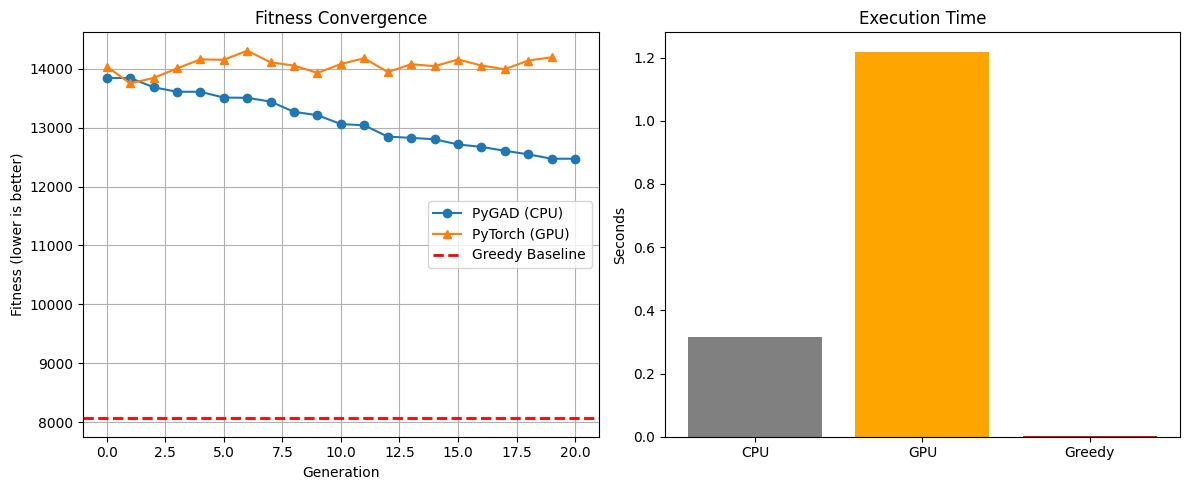

In [2]:
#  Install PyGAD
!pip install pygad --quiet

# ----------------------------
# Imports & Problem Parameters
# ----------------------------
import numpy as np
import torch
import pygad
import time
import matplotlib.pyplot as plt

# Problem Dimensions
num_nodes = 10
num_sources = 3
num_hours = 24
chromosome_length = num_sources * num_nodes * num_hours
POP_SIZE = 30
NUM_GENERATIONS = 20

# Simulated Data
np.random.seed(42)
demand_np = np.random.randint(5, 16, (num_nodes, num_hours))
cost_np = np.random.uniform(2.0, 5.0, (num_sources, num_nodes, num_hours))
loss_np = np.random.uniform(0.05, 0.2, (num_sources, num_nodes))
capacity_np = np.random.randint(50, 100, (num_sources, num_hours))

# -----------------------
# PyTorch GPU-Based GA
# -----------------------
def get_torch_tensors(device):
    return (
        torch.tensor(demand_np, dtype=torch.float32, device=device),
        torch.tensor(cost_np, dtype=torch.float32, device=device),
        torch.tensor(loss_np, dtype=torch.float32, device=device),
        torch.tensor(capacity_np, dtype=torch.float32, device=device)
    )

def pytorch_fitness(chromosome_tensor, demand_tensor, cost_tensor, loss_tensor, capacity_tensor):
    energy = chromosome_tensor.view(num_sources, num_nodes, num_hours)
    cost = torch.sum(energy * cost_tensor)
    loss = torch.sum(energy * loss_tensor[:, :, None])
    supplied = torch.sum(energy * (1 - loss_tensor[:, :, None]), dim=0)
    gap = demand_tensor - supplied
    demand_penalty = torch.sum(torch.square(torch.clamp(gap, min=0)))
    total_usage = torch.sum(energy, dim=1)
    over_capacity = torch.clamp(total_usage - capacity_tensor, min=0)
    constraint_penalty = torch.sum(over_capacity)
    return cost + loss + demand_penalty + 10.0 * constraint_penalty

def run_pytorch_ga(device):
    print(f"\nStarting PyTorch GA on {device}\n")
    demand_tensor, cost_tensor, loss_tensor, capacity_tensor = get_torch_tensors(device)
    population = [torch.rand(chromosome_length, device=device) * 10 for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(NUM_GENERATIONS):
        fitnesses = [pytorch_fitness(chrom, demand_tensor, cost_tensor, loss_tensor, capacity_tensor) for chrom in population]
        best_fitness = min(f.item() for f in fitnesses)
        fitness_curve.append(best_fitness)
        print(f"Generation {gen+1} (Device: {device}): Best Fitness = {best_fitness:.2f}")

        new_population = []
        for _ in range(POP_SIZE // 2):
            parents = np.random.choice(POP_SIZE, 2, replace=False)
            point = np.random.randint(1, chromosome_length - 1)
            c1 = torch.cat([population[parents[0]][:point], population[parents[1]][point:]])
            c2 = torch.cat([population[parents[1]][:point], population[parents[0]][point:]])
            for c in [c1, c2]:
                mutation_mask = torch.rand(chromosome_length, device=device) < 0.05
                c[mutation_mask] = torch.rand(torch.sum(mutation_mask), device=device) * 10
                new_population.append(c)
        population = new_population

    return fitness_curve

# -----------------------
# PyGAD CPU-Based GA
# -----------------------
def fitness_func_ga(ga_instance, solution, solution_idx):
    energy = solution.reshape(num_sources, num_nodes, num_hours)
    supplied = np.sum(energy * (1 - loss_np[:, :, None]), axis=0)
    gap = demand_np - supplied
    demand_penalty = np.sum(np.square(np.clip(gap, 0, None)))
    total_usage = np.sum(energy, axis=1)
    over_capacity = np.clip(total_usage - capacity_np, 0, None)
    constraint_penalty = np.sum(over_capacity)
    cost = np.sum(energy * cost_np)
    loss = np.sum(energy * loss_np[:, :, None])
    return -1.0 * (cost + loss + demand_penalty + 10.0 * constraint_penalty)

def on_generation(ga_instance):
    print(f"CPU Generation {ga_instance.generations_completed} | Best Fitness = {ga_instance.best_solution()[1]:.2f}")

ga_instance = pygad.GA(
    num_generations=NUM_GENERATIONS,
    num_parents_mating=10,
    sol_per_pop=POP_SIZE,
    num_genes=chromosome_length,
    fitness_func=fitness_func_ga,
    mutation_type="random",
    mutation_percent_genes=5,
    gene_space={'low': 0, 'high': 10},
    stop_criteria=["reach_0"],
    on_generation=on_generation
)

# Run PyGAD (CPU)
print("Starting PyGAD (CPU) GA...\n")
start_cpu = time.time()
ga_instance.run()
end_cpu = time.time()
fitness_curve_cpu = -1 * np.array(ga_instance.best_solutions_fitness)
cpu_time = end_cpu - start_cpu
print(f"\n CPU Time: {cpu_time:.2f} seconds")

# -----------------------
# Run PyTorch (GPU)
# -----------------------
fitness_curve_gpu = []
gpu_time = 0.0
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    print("\nStarting PyTorch (GPU) GA...\n")
    start_gpu = time.time()
    fitness_curve_gpu = run_pytorch_ga(device)
    torch.cuda.synchronize()
    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu
    print(f"\n GPU Time: {gpu_time:.2f} seconds")
else:
    print("\n GPU not available")

    # -----------------------
# Greedy BaselineA
def run_greedy_baseline():
    energy = np.zeros((num_sources, num_nodes, num_hours))
    available_capacity = capacity_np.copy()

    for h in range(num_hours):
        for n in range(num_nodes):
            demand_remaining = demand_np[n, h]
            effective_costs = cost_np[:, n, h] / (1 - loss_np[:, n])
            source_order = np.argsort(effective_costs)

            for s in source_order:
                if demand_remaining <= 0:
                    break

                effective_supply = available_capacity[s, h] * (1 - loss_np[s, n])
                if effective_supply <= 0:
                    continue

                required_energy = demand_remaining / (1 - loss_np[s, n])
                energy_to_supply = min(required_energy, available_capacity[s, h])
                energy[s, n, h] = energy_to_supply
                available_capacity[s, h] -= energy_to_supply
                demand_remaining -= energy_to_supply * (1 - loss_np[s, n])

    supplied = np.sum(energy * (1 - loss_np[:, :, None]), axis=0)
    gap = demand_np - supplied
    demand_penalty = np.sum(np.square(np.clip(gap, 0, None)))
    total_usage = np.sum(energy, axis=1)
    over_capacity = np.clip(total_usage - capacity_np, 0, None)
    constraint_penalty = np.sum(over_capacity)
    cost = np.sum(energy * cost_np)
    loss = np.sum(energy * loss_np[:, :, None])
    total_fitness = cost + loss + demand_penalty + 10.0 * constraint_penalty

    return total_fitness, energy, cost, loss, demand_penalty, constraint_penalty


# Run Greedy
# Run Greedy
greedy_fitness, energy, cost, loss, demand_penalty, constraint_penalty = run_greedy_baseline()
print(f"\nGreedy Baseline Fitness = {greedy_fitness:.2f}")

print("Greedy Breakdown:")
print(f" - Cost: {cost:.2f}")
print(f" - Loss: {loss:.2f}")
print(f" - Demand Penalty: {demand_penalty:.2f}")
print(f" - Constraint Penalty: {constraint_penalty:.2f}")

# -----------------------
# -----------------------
# Visualization
# -----------------------
plt.figure(figsize=(12, 5))

# Plot 1: Fitness Curves
plt.subplot(1, 2, 1)
plt.plot(fitness_curve_cpu, label="PyGAD (CPU)", marker='o')
if fitness_curve_gpu:
    plt.plot(fitness_curve_gpu, label="PyTorch (GPU)", marker='^')
# Add greedy as a constant horizontal line
plt.axhline(y=greedy_fitness, color='red', linestyle='--', linewidth=2, label='Greedy Baseline')
plt.title("Fitness Convergence")
plt.xlabel("Generation")
plt.ylabel("Fitness (lower is better)")
plt.legend()
plt.grid(True)

# Plot 2: Execution Time
plt.subplot(1, 2, 2)
labels = ['CPU']
times = [cpu_time]
colors = ['gray']
if gpu_time > 0:
    labels.append('GPU')
    times.append(gpu_time)
    colors.append('orange')
# Add greedy (assume near-zero time, so we show a tiny bar)
labels.append('Greedy')
times.append(0.001)  # Approx. 1 ms for plotting purposes
colors.append('red')
plt.bar(labels, times, color=colors)
plt.title("Execution Time")
plt.ylabel("Seconds")

plt.tight_layout()
plt.show()



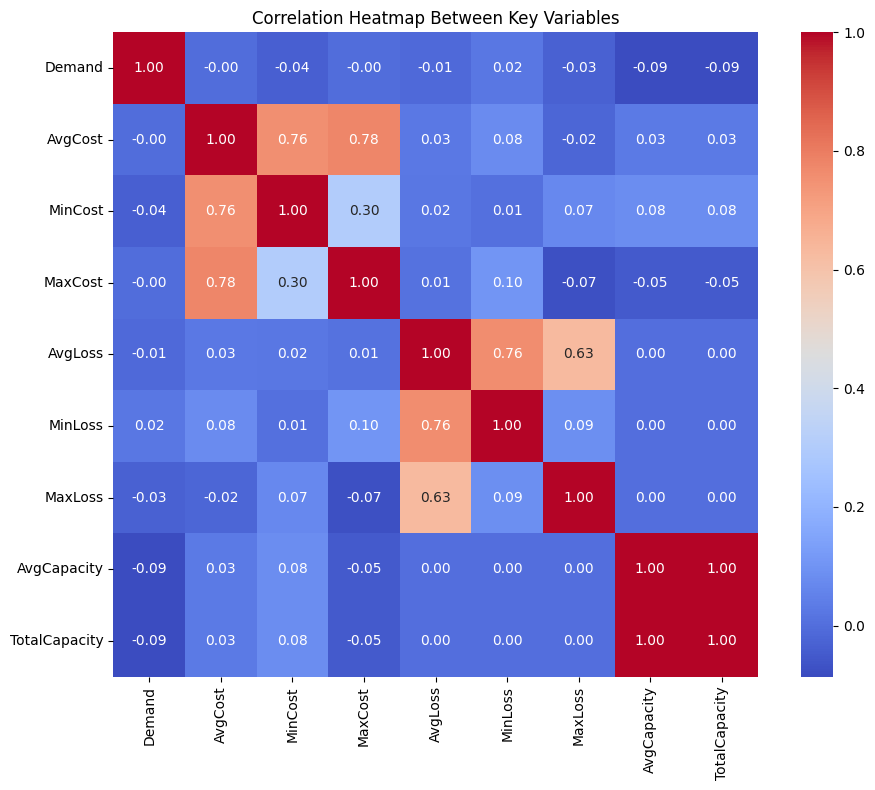

In [3]:
import seaborn as sns
import pandas as pd

# -----------------------
# Correlation Heatmap
# -----------------------

# Flatten & summarize features per (node, hour) pair
records = []
for n in range(num_nodes):
    for h in range(num_hours):
        record = {
            "Node": n,
            "Hour": h,
            "Demand": demand_np[n, h],
            "AvgCost": np.mean(cost_np[:, n, h]),
            "MinCost": np.min(cost_np[:, n, h]),
            "MaxCost": np.max(cost_np[:, n, h]),
            "AvgLoss": np.mean(loss_np[:, n]),
            "MinLoss": np.min(loss_np[:, n]),
            "MaxLoss": np.max(loss_np[:, n]),
            "AvgCapacity": np.mean(capacity_np[:, h]),
            "TotalCapacity": np.sum(capacity_np[:, h])
        }
        records.append(record)

df = pd.DataFrame(records)

# Compute correlation matrix
corr_matrix = df.drop(columns=["Node", "Hour"]).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap Between Key Variables")
plt.tight_layout()
plt.show()
